In [42]:
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
import random
# let it be
torch.cuda.empty_cache() 

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [43]:
#!nvidia-smi
import torch
torch.cuda.is_available()

True

In [44]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [45]:
# Dataloader modes
DATA_MODES = ['train', 'val', 'test']
# all samples 224x224 px
RESCALE_SIZE = 224
#
DEVICE = torch.device("cuda")

### Data loading

In [46]:
class SimpsonsDataset(Dataset):
    """
    DataLoader that scales picture and turns it into torch tensor
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if (self.mode != 'test'):
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if (self.mode == 'test'):
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [47]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [48]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

### Check class balance and fix it

In [49]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [50]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1000)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

In [51]:
def analysis(labels, min_level=True, max_level=True):
    data = get_count(labels)
    show_data(data)

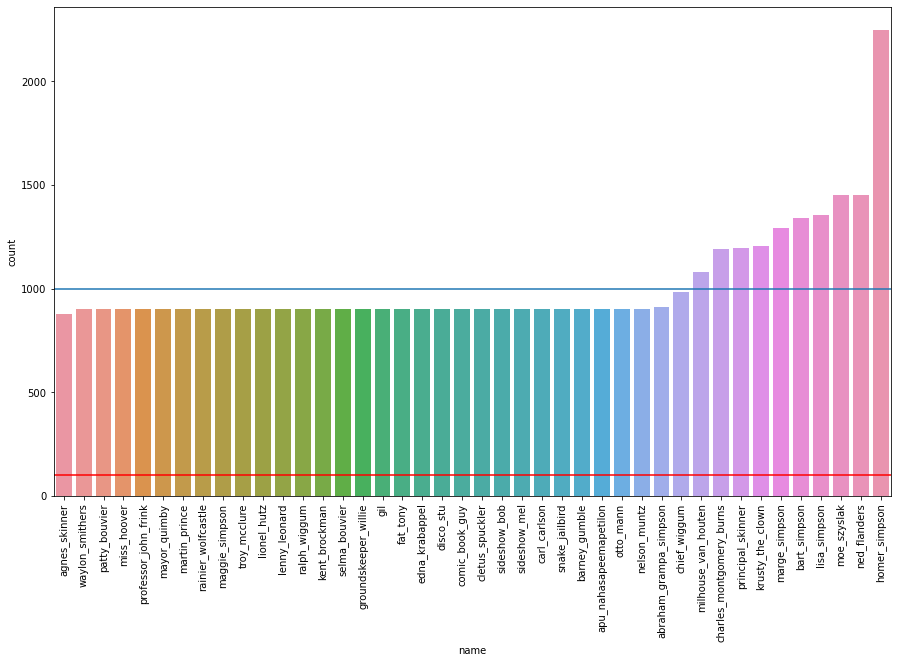

In [52]:
analysis(train_val_labels)

In [53]:
# labels, l_ind, l_cnt = np.unique(train_val_labels, return_index = True, return_counts = True)
# subset_ind = []
# upper_bound = 900
# for i in range(len(labels)):
#     if (l_cnt[i] > upper_bound):
#         subset_ind.extend(np.random.choice(l_cnt[i], upper_bound, replace=False) + l_ind[i])
#     else:
#         subset_ind.extend(np.arange(l_cnt[i]) + l_ind[i])

### Data augmentation

In [54]:
# data = get_count(np.array(train_val_labels)[subset_ind])
# data['to_add'] = data['count'].apply(lambda x: upper_bound - x if x < upper_bound else 0)
# data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)

# augmenters = {
#     'Perspective': transforms.Compose([
#                                 transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomPerspective(distortion_scale = 0.4, p = 1) 
#                                 ]),
#     'Rotate': transforms.Compose([
#                                 transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomAffine(degrees=(-25, 25), translate=(0.1, 0.2), scale = (0.8, 1.2))
#                                 ])
# }

# def load_image(file):
#     image = Image.open(file)
#     image.load()
#     return image

# for image_path in tqdm(train_val_files):
#     path = image_path.parents[0]
#     character = image_path.parent.name
#     img = load_image(image_path)
#     # if we don't need to add any images, we can continue without transformation
#     if data.loc[character]['to_add'] <= 0:
#         continue

#     # if number of images to create for one iteration is greater than the rest of images to create,
#     # we should use 'to_add' instead of 'one_iteration'  
#     if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
#         iter_size = data.loc[character]['to_add']
#     else:
#         iter_size = data.loc[character]['one_iteration']
#     data.loc[character]['to_add'] -= iter_size
    
#     for i in range(iter_size):
#         augmenter = random.choice(list(augmenters.values()))
#         aug_img = augmenter(img)
#         aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

In [55]:
# train_val_files = torch.utils.data.Subset(train_val_files, subset_ind)

### Spilt and etc. 

In [56]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [57]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Dataset examples

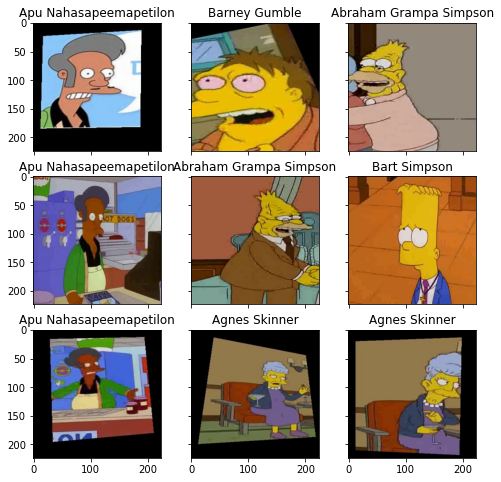

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Neural network architecture

In [59]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(12),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.MaxPool2d(kernel_size=2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 5 * 5, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.out = nn.Linear(1024, n_classes)
      

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        logits = self.out(x)
        return logits

Model params debug

In [60]:
# from torchsummary import summary
# net = SimpleCnn(10)
# summary(net.cuda(), (3, 224, 224))
# net = SimpleCnn(10).to(DEVICE)

In [61]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [62]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [63]:
def train(train_files, val_files, model, epochs, batch_size, initial_lr = 0.005, lr_decay = 0.5,
         decay_threshold = 0, decay_step = 4, save_best = True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    best_score = 0
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = initial_lr)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = decay_step, gamma=lr_decay)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # train
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            # validation
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            # save best
            if (save_best and epoch > 15 and val_acc > best_score + 0.005):
                torch.save(simple_cnn, 'model.pt')
            # scheduler 
            if epoch >= decay_threshold:
                scheduler.step()
            # info output 
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [64]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [65]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(simple_cnn)

we will classify :42


### Learning process

In [66]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [67]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=30, batch_size=32) 

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.3071801769084064


epoch:   3%|██▍                                                                      | 1/30 [03:49<1:50:50, 229.33s/it]


Epoch 001 train_loss: 2.3072     val_loss 1.3407 train_acc 0.3853 val_acc 0.6141
loss 1.1170060916402111


epoch:   7%|████▊                                                                    | 2/30 [07:30<1:44:40, 224.29s/it]


Epoch 002 train_loss: 1.1170     val_loss 0.8610 train_acc 0.6772 val_acc 0.7569
loss 0.632619123379032


epoch:  10%|███████▎                                                                 | 3/30 [11:13<1:40:43, 223.82s/it]


Epoch 003 train_loss: 0.6326     val_loss 0.6060 train_acc 0.8114 val_acc 0.8232
loss 0.41134595605677393


epoch:  13%|█████████▋                                                               | 4/30 [15:00<1:37:36, 225.27s/it]


Epoch 004 train_loss: 0.4113     val_loss 0.5866 train_acc 0.8751 val_acc 0.8382
loss 0.12025546595181474


epoch:  17%|████████████▏                                                            | 5/30 [18:43<1:33:31, 224.44s/it]


Epoch 005 train_loss: 0.1203     val_loss 0.4488 train_acc 0.9614 val_acc 0.8930
loss 0.08380457472630023


epoch:  20%|██████████████▌                                                          | 6/30 [22:28<1:29:46, 224.42s/it]


Epoch 006 train_loss: 0.0838     val_loss 0.5184 train_acc 0.9732 val_acc 0.8769
loss 0.08178512626480584


epoch:  23%|█████████████████                                                        | 7/30 [26:10<1:25:47, 223.80s/it]


Epoch 007 train_loss: 0.0818     val_loss 0.5357 train_acc 0.9743 val_acc 0.8762
loss 0.0653098544147136


epoch:  27%|███████████████████▍                                                     | 8/30 [29:55<1:22:07, 223.98s/it]


Epoch 008 train_loss: 0.0653     val_loss 0.5631 train_acc 0.9801 val_acc 0.8795
loss 0.010818677816467077


epoch:  30%|█████████████████████▉                                                   | 9/30 [33:45<1:19:04, 225.94s/it]


Epoch 009 train_loss: 0.0108     val_loss 0.4640 train_acc 0.9968 val_acc 0.9116
loss 0.002201356851326446


epoch:  33%|████████████████████████                                                | 10/30 [37:30<1:15:15, 225.78s/it]


Epoch 010 train_loss: 0.0022     val_loss 0.4592 train_acc 0.9995 val_acc 0.9091
loss 0.002123855383066304


epoch:  37%|██████████████████████████▍                                             | 11/30 [41:24<1:12:17, 228.31s/it]


Epoch 011 train_loss: 0.0021     val_loss 0.4621 train_acc 0.9996 val_acc 0.9111
loss 0.023785941439485755


epoch:  40%|████████████████████████████▊                                           | 12/30 [45:09<1:08:11, 227.31s/it]


Epoch 012 train_loss: 0.0238     val_loss 0.5394 train_acc 0.9933 val_acc 0.8952
loss 0.00489477596439328


epoch:  43%|███████████████████████████████▏                                        | 13/30 [49:01<1:04:46, 228.63s/it]


Epoch 013 train_loss: 0.0049     val_loss 0.4593 train_acc 0.9985 val_acc 0.9120
loss 0.0011779272397617242


epoch:  47%|█████████████████████████████████▌                                      | 14/30 [52:53<1:01:12, 229.51s/it]


Epoch 014 train_loss: 0.0012     val_loss 0.4536 train_acc 0.9997 val_acc 0.9131
loss 0.0005559768737828113


epoch:  50%|█████████████████████████████████████                                     | 15/30 [56:45<57:33, 230.25s/it]


Epoch 015 train_loss: 0.0006     val_loss 0.4467 train_acc 0.9998 val_acc 0.9142
loss 0.0007448818708949745


epoch:  53%|██████████████████████████████████████▍                                 | 16/30 [1:00:45<54:27, 233.36s/it]


Epoch 016 train_loss: 0.0007     val_loss 0.4571 train_acc 0.9997 val_acc 0.9122
loss 0.0005204547201726378


epoch:  57%|████████████████████████████████████████▊                               | 17/30 [1:04:33<50:14, 231.85s/it]


Epoch 017 train_loss: 0.0005     val_loss 0.4461 train_acc 0.9998 val_acc 0.9153
loss 0.0004872450470866293


epoch:  60%|███████████████████████████████████████████▏                            | 18/30 [1:08:17<45:53, 229.44s/it]


Epoch 018 train_loss: 0.0005     val_loss 0.4612 train_acc 0.9997 val_acc 0.9153
loss 0.00034199207314428376


epoch:  63%|█████████████████████████████████████████████▌                          | 19/30 [1:12:05<41:57, 228.86s/it]


Epoch 019 train_loss: 0.0003     val_loss 0.4661 train_acc 0.9998 val_acc 0.9154
loss 0.0005994561817956985


epoch:  67%|████████████████████████████████████████████████                        | 20/30 [1:15:48<37:50, 227.04s/it]


Epoch 020 train_loss: 0.0006     val_loss 0.5773 train_acc 0.9997 val_acc 0.9053
loss 0.0004584057982304072


epoch:  70%|██████████████████████████████████████████████████▍                     | 21/30 [1:19:30<33:51, 225.75s/it]


Epoch 021 train_loss: 0.0005     val_loss 0.5239 train_acc 0.9998 val_acc 0.9132
loss 0.00025895008345824767


epoch:  73%|████████████████████████████████████████████████████▊                   | 22/30 [1:23:14<30:00, 225.02s/it]


Epoch 022 train_loss: 0.0003     val_loss 0.5138 train_acc 0.9998 val_acc 0.9154
loss 0.00024476519869292857


epoch:  77%|███████████████████████████████████████████████████████▏                | 23/30 [1:26:56<26:09, 224.20s/it]


Epoch 023 train_loss: 0.0002     val_loss 0.5286 train_acc 0.9998 val_acc 0.9133
loss 0.0002713443175782776


epoch:  80%|█████████████████████████████████████████████████████████▌              | 24/30 [1:30:38<22:21, 223.61s/it]


Epoch 024 train_loss: 0.0003     val_loss 0.5422 train_acc 0.9998 val_acc 0.9143
loss 0.00019643697152279938


epoch:  83%|████████████████████████████████████████████████████████████            | 25/30 [1:34:20<18:35, 223.18s/it]


Epoch 025 train_loss: 0.0002     val_loss 0.5397 train_acc 0.9998 val_acc 0.9150
loss 0.00016473465711905173


epoch:  87%|██████████████████████████████████████████████████████████████▍         | 26/30 [1:38:00<14:48, 222.20s/it]


Epoch 026 train_loss: 0.0002     val_loss 0.5433 train_acc 0.9998 val_acc 0.9162
loss 0.00016797924199729887


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [1:41:42<11:06, 222.17s/it]


Epoch 027 train_loss: 0.0002     val_loss 0.5496 train_acc 0.9999 val_acc 0.9158
loss 0.0001706802850001037


epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [1:45:27<07:25, 222.87s/it]


Epoch 028 train_loss: 0.0002     val_loss 0.5655 train_acc 0.9999 val_acc 0.9152
loss 0.00014878270292238577


epoch:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [1:49:08<03:42, 222.21s/it]


Epoch 029 train_loss: 0.0001     val_loss 0.5670 train_acc 0.9999 val_acc 0.9148
loss 0.00014679388346513968


epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [1:52:52<00:00, 225.74s/it]


Epoch 030 train_loss: 0.0001     val_loss 0.5700 train_acc 0.9999 val_acc 0.9147


### Learning grapghs

In [68]:
loss, acc, val_loss, val_acc = zip(*history)

In [69]:
val_acc = (torch.stack(val_acc)).tolist()

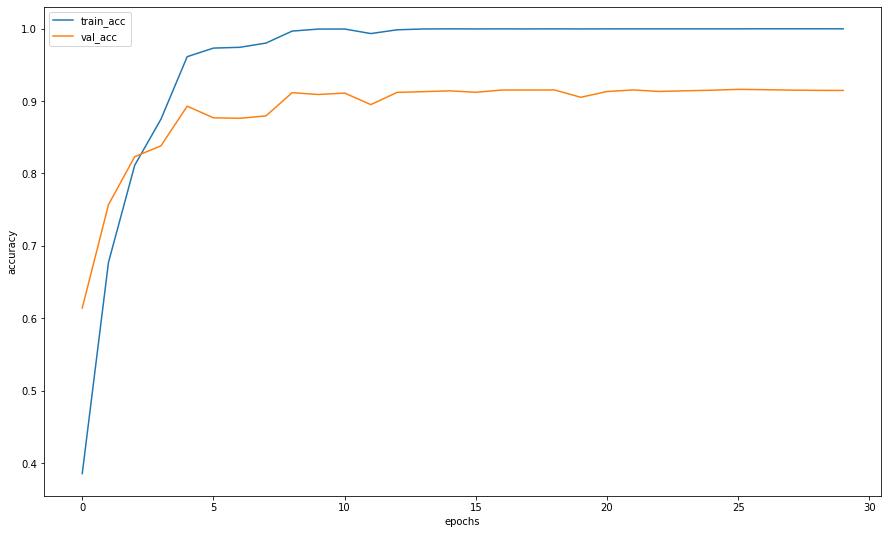

In [70]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### Submit

In [72]:
best_model = torch.load('model.pt')

In [73]:
simple_cnn = best_model

In [75]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [76]:
import pandas as pd
from natsort import index_natsorted
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.sort_values(
   by="Id",
   key=lambda x: np.argsort(index_natsorted(my_submit["Id"]))
)
my_submit.to_csv('submission.csv', index=False)